In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [3]:
np.random.seed(1)
num_drivers = len(rho)
y_array = np.zeros((Nout,num_drivers))
Losses_out = np.zeros((Nout,K))

for s in range(1,Nout+1):
    
    nr_vec = np.random.randn(num_drivers,1)
    y_array[s-1,:] = np.dot(sqrt_rho,nr_vec).T
    z_array = np.random.randn(K,1)
    
    for i in range(1,K+1):
        
        credit_driver = int(driver[i-1])
        if credit_driver != 50:
            w_array = beta[i-1] * y_array[s-1,credit_driver] + np.sqrt(1 - beta[i-1]**2) * z_array[i-1]
        buffer = sorted(np.append(w_array,CS_Bdry[i-1,:]))
        # Calculated out-of-sample losses (100000 x 100) 
        # Losses_out (sparse matrix)
        Losses_out[s-1,i-1] = exposure[i-1,np.argwhere(buffer == w_array)]

In [4]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        
        loss = sorted(np.dot(Losses_out,x0[portN]))
        VaRout[portN, q] = loss[int(math.ceil(Nout * alf)) -1]
        VaRinN[portN, q] = np.mean(loss) + scs.norm.ppf(alf) * np.std(loss)
        CVaRout[portN, q] = (1 / (Nout*(1-alf))) * ((math.ceil(Nout*alf)-Nout*alf) * VaRout[portN,q] + sum(loss[int(math.ceil(Nout*alf)):]))
        CVaRinN[portN, q] = np.mean(loss) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * np.std(loss)

In [5]:
np.random.seed(100001)
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

for tr in range(1, N_trials + 1):
    
    # Monte Carlo approximation 1
    
    y_in_sample1, Losses_inMC1 = np.zeros((np.int(np.ceil(Nin/Ns)),num_drivers)), np.zeros((Nin,K))

    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        nr_vec1 = np.random.randn(num_drivers,1)
        y_in_sample1[s-1,:] = np.dot(sqrt_rho,nr_vec1).T

        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            z_in_sample1 = np.random.randn(K,1)

    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1
            
            for i in range(1,K+1):
                credit_driver1 = int(driver[i-1])
                if credit_driver1 != 50:
                    w_in_sample1 = beta[i-1] * y_in_sample1[s-1,credit_driver1] + np.sqrt(1 - beta[i-1]**2) * z_in_sample1[i-1]
                buffer1 = sorted(np.append(w_in_sample1,CS_Bdry[i-1,:]))
                Losses_inMC1[5*(s-1)+si-1,i-1] = exposure[i-1,np.argwhere(buffer1==w_in_sample1)]

    # Monte Carlo approximation 2

    y_in_sample2, Losses_inMC2 = np.zeros((Nin,num_drivers)), np.zeros((Nin,K))

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        nr_vec2 = np.random.randn(num_drivers,1)
        y_in_sample2[s-1,:] = np.dot(sqrt_rho,nr_vec2).T
        z_in_sample2 = np.random.randn(K,1)

    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2

        for i in range(1,K+1):
                credit_driver2 = int(driver[i-1])
                if credit_driver2 != 50:
                    w_in_sample2 = beta[i-1] * y_in_sample2[s-1,credit_driver2] + np.sqrt(1 - beta[i-1]**2) * z_in_sample2[i-1]
                buffer2 = sorted(np.append(w_in_sample2,CS_Bdry[i-1,:]))
                Losses_inMC2[s-1,i-1] = exposure[i-1,np.argwhere(buffer2==w_in_sample2)]

    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # Compute portfolio loss
            portf_loss_inMC1 = sorted(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 = sorted(np.dot(Losses_inMC2,x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) -1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) -1]
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC1[portN,q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC2[portN,q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * sigma_p_MC2

In [6]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $38307840.66, CVaR 99.0% = $45932665.13
In-sample MC1: VaR 99.0% = $38113787.21, CVaR 99.0% = $45621046.64
In-sample MC2: VaR 99.0% = $37999819.50, CVaR 99.0% = $45811460.43
In-sample No: VaR 99.0% = $26637962.98, CVaR 99.0% = $29590272.82
In-sample N1: VaR 99.0% = $26531257.75, CVaR 99.0% = $29471222.09
In-sample N2: VaR 99.0% = $26585907.19, CVaR 99.0% = $29531695.05

Out-of-sample: VaR 99.9% = $56488627.28, CVaR 99.9% = $63397992.27
In-sample MC1: VaR 99.9% = $54614904.71, CVaR 99.9% = $61526674.80
In-sample MC2: VaR 99.9% = $55161243.49, CVaR 99.9% = $62830831.49
In-sample No: VaR 99.9% = $33293163.63, CVaR 99.9% = $35705235.32
In-sample N1: VaR 99.9% = $33158628.75, CVaR 99.9% = $35560614.02
In-sample N2: VaR 99.9% = $33226405.75, CVaR 99.9% = $35633148.90


Portfolio 2:

Out-of-sample: VaR 99.0% = $27969947.49, CVaR 99.0% = $33572245.08
In-sample MC1: VaR 99.0% = $27733280.68, CVaR 99.0% = $33386746.20
In-sample MC2: VaR 99.0% = $27712730

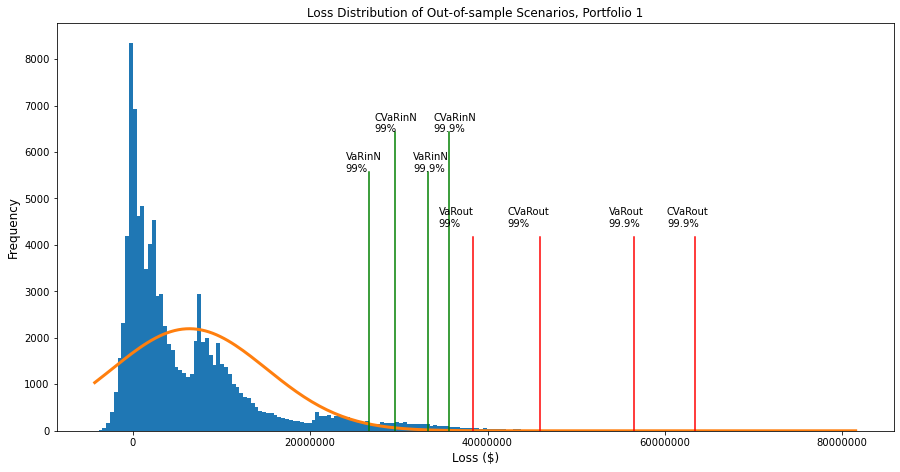

In [7]:
# Plot results

# Loss Distribution of Out-of-sample Scenarios, Portfolio 1
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_out,x0[0]), 200)
f_n = (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)
plt.plot(bins, f_n, linewidth=3)

plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(f_count)/2], color='r')
plt.text(0.90 * VaRout[0,0], max(f_count) / 1.9, 'VaRout\n99%')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(f_count)/2], color='r')
plt.text(0.95 * VaRout[0,1], max(f_count) / 1.9, 'VaRout\n99.9%')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(f_count)/2], color='r')
plt.text(0.92 * CVaRout[0,0], max(f_count) / 1.9, 'CVaRout\n99%')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(f_count)/2], color='r')
plt.text(0.95 * CVaRout[0,1], max(f_count) / 1.9, 'CVaRout\n99.9%')
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(f_count)/1.5], color='g')
plt.text(0.90 * VaRinN[0,0], max(f_count) / 1.5, 'VaRinN\n99%')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(f_count)/1.5], color='g')
plt.text(0.95 * VaRinN[0,1], max(f_count) / 1.5, 'VaRinN\n99.9%')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(f_count)/1.3], color='g')
plt.text(0.92 * CVaRinN[0,0], max(f_count) / 1.3, 'CVaRinN\n99%')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(f_count)/1.3], color='g')
plt.text(0.95 * CVaRinN[0,1], max(f_count) / 1.3, 'CVaRinN\n99.9%')

plt.title('Loss Distribution of Out-of-sample Scenarios, Portfolio 1')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

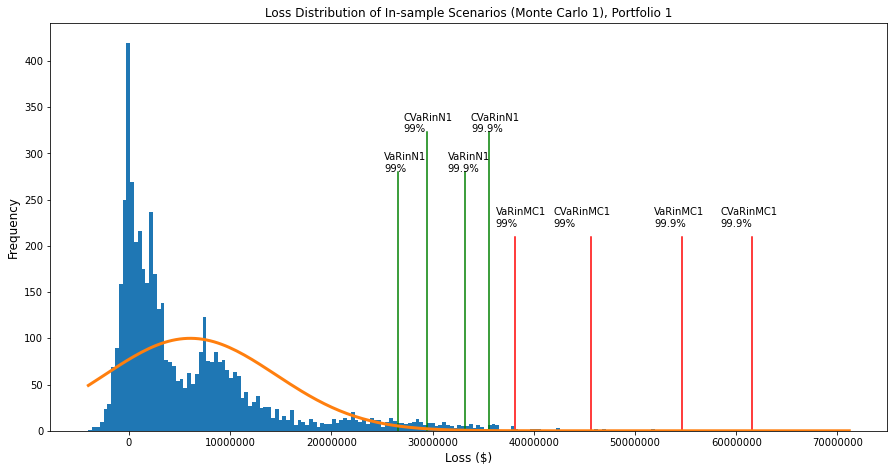

In [8]:
# Loss Distribution of In-sample Scenarios (Monte Carlo 1), Portfolio 1
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC1,x0[0]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC1,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC1,x0[0]))) / np.std(np.dot(Losses_inMC1,x0[0]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)

plt.plot([np.mean(VaRinMC1[0, 0]), np.mean(VaRinMC1[0, 0])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(VaRinMC1[0, 0]), max(f_count) / 1.9, 'VaRinMC1\n99%')
plt.plot([np.mean(VaRinMC1[0, 1]), np.mean(VaRinMC1[0, 1])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(VaRinMC1[0, 1]), max(f_count) / 1.9, 'VaRinMC1\n99.9%')
plt.plot([np.mean(CVaRinMC1[0, 0]), np.mean(CVaRinMC1[0, 0])], [0, max(f_count)/2], color='r')
plt.text(0.92 * np.mean(CVaRinMC1[0, 0]), max(f_count) / 1.9, 'CVaRinMC1\n99%')
plt.plot([np.mean(CVaRinMC1[0, 1]), np.mean(CVaRinMC1[0, 1])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(CVaRinMC1[0, 1]), max(f_count) / 1.9, 'CVaRinMC1\n99.9%')
plt.plot([np.mean(VaRinN1[0, 0]), np.mean(VaRinN1[0, 0])], [0, max(f_count)/1.5], color='g')
plt.text(0.95 * np.mean(VaRinN1[0, 0]), max(f_count) / 1.5, 'VaRinN1\n99%')
plt.plot([np.mean(VaRinN1[0, 1]), np.mean(VaRinN1[0, 1])], [0, max(f_count)/1.5], color='g')
plt.text(0.95 * np.mean(VaRinN1[0, 1]), max(f_count) / 1.5, 'VaRinN1\n99.9%')
plt.plot([np.mean(CVaRinN1[0, 0]), np.mean(CVaRinN1[0, 0])], [0, max(f_count)/1.3], color='g')
plt.text(0.92 * np.mean(CVaRinN1[0, 0]), max(f_count) / 1.3, 'CVaRinN1\n99%')
plt.plot([np.mean(CVaRinN1[0, 1]), np.mean(CVaRinN1[0, 1])], [0, max(f_count)/1.3], color='g')
plt.text(0.95 * np.mean(CVaRinN1[0, 1]), max(f_count) / 1.3, 'CVaRinN1\n99.9%')

plt.plot(bins, f_n, linewidth=3)
plt.title('Loss Distribution of In-sample Scenarios (Monte Carlo 1), Portfolio 1')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

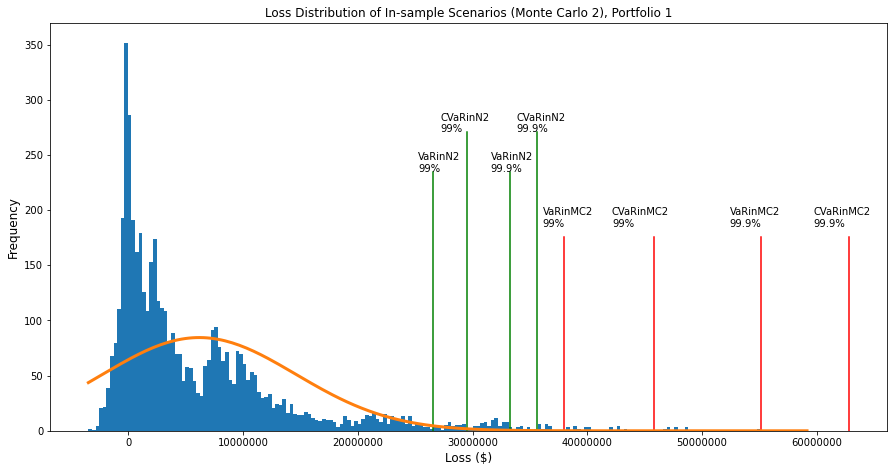

In [16]:
# Loss Distribution of In-sample Scenarios (Monte Carlo 2), Portfolio 1
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC2,x0[0]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC2,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC2,x0[0]))) / np.std(np.dot(Losses_inMC2,x0[0]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)

plt.plot([np.mean(VaRinMC2[0, 0]), np.mean(VaRinMC2[0, 0])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(VaRinMC2[0, 0]), max(f_count) / 1.9, 'VaRinMC2\n99%')
plt.plot([np.mean(VaRinMC2[0, 1]), np.mean(VaRinMC2[0, 1])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(VaRinMC2[0, 1]), max(f_count) / 1.9, 'VaRinMC2\n99.9%')
plt.plot([np.mean(CVaRinMC2[0, 0]), np.mean(CVaRinMC2[0, 0])], [0, max(f_count)/2], color='r')
plt.text(0.92 * np.mean(CVaRinMC2[0, 0]), max(f_count) / 1.9, 'CVaRinMC2\n99%')
plt.plot([np.mean(CVaRinMC2[0, 1]), np.mean(CVaRinMC2[0, 1])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(CVaRinMC2[0, 1]), max(f_count) / 1.9, 'CVaRinMC2\n99.9%')
plt.plot([np.mean(VaRinN2[0, 0]), np.mean(VaRinN2[0, 0])], [0, max(f_count)/1.5], color='g')
plt.text(0.95 * np.mean(VaRinN2[0, 0]), max(f_count) / 1.5, 'VaRinN2\n99%')
plt.plot([np.mean(VaRinN2[0, 1]), np.mean(VaRinN2[0, 1])], [0, max(f_count)/1.5], color='g')
plt.text(0.95 * np.mean(VaRinN2[0, 1]), max(f_count) / 1.5, 'VaRinN2\n99.9%')
plt.plot([np.mean(CVaRinN2[0, 0]), np.mean(CVaRinN2[0, 0])], [0, max(f_count)/1.3], color='g')
plt.text(0.92 * np.mean(CVaRinN2[0, 0]), max(f_count) / 1.3, 'CVaRinN2\n99%')
plt.plot([np.mean(CVaRinN2[0, 1]), np.mean(CVaRinN2[0, 1])], [0, max(f_count)/1.3], color='g')
plt.text(0.95 * np.mean(CVaRinN2[0, 1]), max(f_count) / 1.3, 'CVaRinN2\n99.9%')

plt.plot(bins, f_n, linewidth=3)
plt.title('Loss Distribution of In-sample Scenarios (Monte Carlo 2), Portfolio 1')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

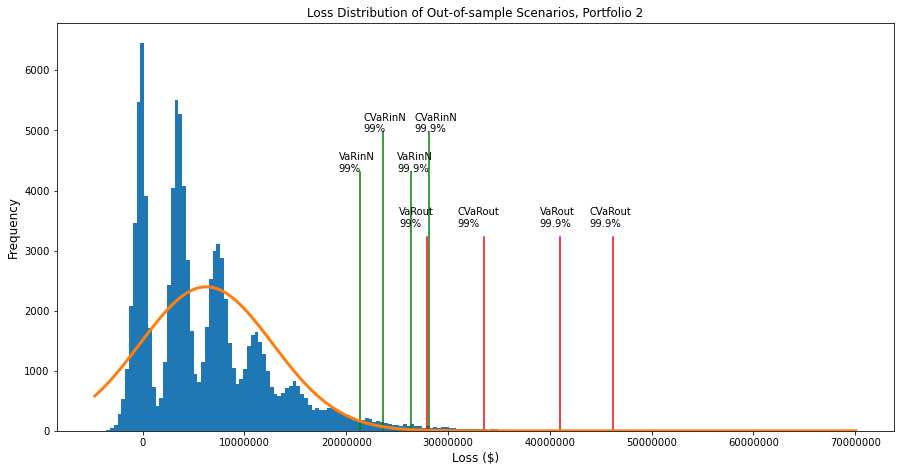

In [10]:
# Loss Distribution of Out-of-sample Scenarios, Portfolio 2
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_out,x0[1]), 200)
f_n = (1 / (np.std(np.dot(Losses_out,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_out,x0[1]))) / np.std(np.dot(Losses_out,x0[1]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)

plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(f_count)/2], color='r')
plt.text(0.90 * VaRout[1,0], max(f_count) / 1.9, 'VaRout\n99%')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(f_count)/2], color='r')
plt.text(0.95 * VaRout[1,1], max(f_count) / 1.9, 'VaRout\n99.9%')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(f_count)/2], color='r')
plt.text(0.92 * CVaRout[1,0], max(f_count) / 1.9, 'CVaRout\n99%')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(f_count)/2], color='r')
plt.text(0.95 * CVaRout[1,1], max(f_count) / 1.9, 'CVaRout\n99.9%')
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(f_count)/1.5], color='g')
plt.text(0.90 * VaRinN[1,0], max(f_count) / 1.5, 'VaRinN\n99%')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(f_count)/1.5], color='g')
plt.text(0.95 * VaRinN[1,1], max(f_count) / 1.5, 'VaRinN\n99.9%')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(f_count)/1.3], color='g')
plt.text(0.92 * CVaRinN[1,0], max(f_count) / 1.3, 'CVaRinN\n99%')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(f_count)/1.3], color='g')
plt.text(0.95 * CVaRinN[1,1], max(f_count) / 1.3, 'CVaRinN\n99.9%')

plt.plot(bins, f_n, linewidth=3)
plt.title('Loss Distribution of Out-of-sample Scenarios, Portfolio 2')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

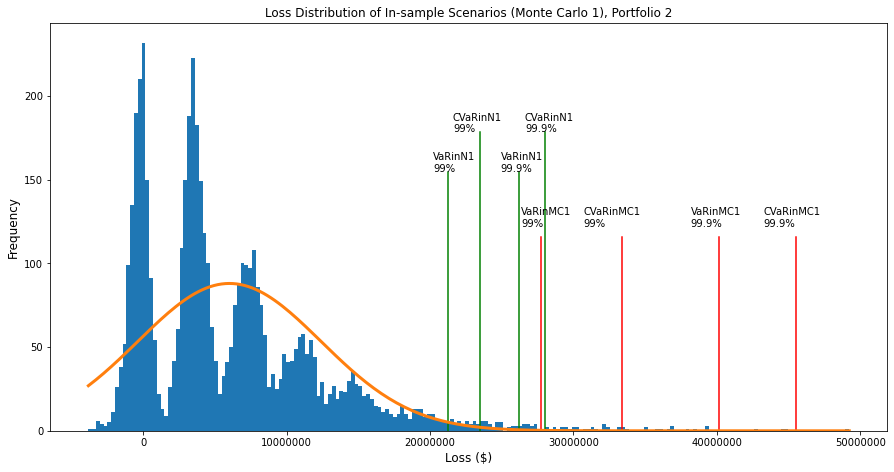

In [11]:
# Loss Distribution of In-sample Scenarios (Monte Carlo 1), Portfolio 2
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC1,x0[1]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC1,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC1,x0[1]))) / np.std(np.dot(Losses_inMC1,x0[1]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)

plt.plot([np.mean(VaRinMC1[1, 0]), np.mean(VaRinMC1[1, 0])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(VaRinMC1[1, 0]), max(f_count) / 1.9, 'VaRinMC1\n99%')
plt.plot([np.mean(VaRinMC1[1, 1]), np.mean(VaRinMC1[1, 1])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(VaRinMC1[1, 1]), max(f_count) / 1.9, 'VaRinMC1\n99.9%')
plt.plot([np.mean(CVaRinMC1[1, 0]), np.mean(CVaRinMC1[1, 0])], [0, max(f_count)/2], color='r')
plt.text(0.92 * np.mean(CVaRinMC1[1, 0]), max(f_count) / 1.9, 'CVaRinMC1\n99%')
plt.plot([np.mean(CVaRinMC1[1, 1]), np.mean(CVaRinMC1[1, 1])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(CVaRinMC1[1, 1]), max(f_count) / 1.9, 'CVaRinMC1\n99.9%')
plt.plot([np.mean(VaRinN1[1, 0]), np.mean(VaRinN1[1, 0])], [0, max(f_count)/1.5], color='g')
plt.text(0.95 * np.mean(VaRinN1[1, 0]), max(f_count) / 1.5, 'VaRinN1\n99%')
plt.plot([np.mean(VaRinN1[1, 1]), np.mean(VaRinN1[1, 1])], [0, max(f_count)/1.5], color='g')
plt.text(0.95 * np.mean(VaRinN1[1, 1]), max(f_count) / 1.5, 'VaRinN1\n99.9%')
plt.plot([np.mean(CVaRinN1[1, 0]), np.mean(CVaRinN1[1, 0])], [0, max(f_count)/1.3], color='g')
plt.text(0.92 * np.mean(CVaRinN1[1, 0]), max(f_count) / 1.3, 'CVaRinN1\n99%')
plt.plot([np.mean(CVaRinN1[1, 1]), np.mean(CVaRinN1[1, 1])], [0, max(f_count)/1.3], color='g')
plt.text(0.95 * np.mean(CVaRinN1[1, 1]), max(f_count) / 1.3, 'CVaRinN1\n99.9%')

plt.plot(bins, f_n, linewidth=3)
plt.title('Loss Distribution of In-sample Scenarios (Monte Carlo 1), Portfolio 2')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

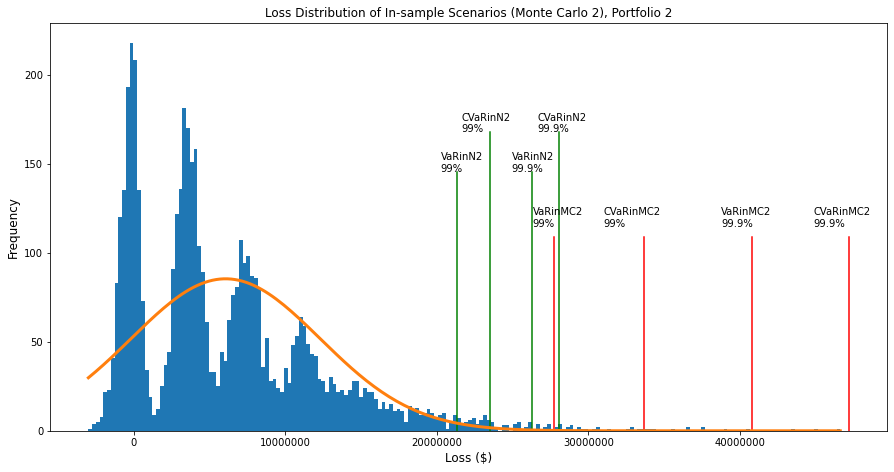

In [17]:
# Loss Distribution of In-sample Scenarios (Monte Carlo 2), Portfolio 2
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC2,x0[1]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC2,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC2,x0[1]))) / np.std(np.dot(Losses_inMC2,x0[1]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)

plt.plot([np.mean(VaRinMC2[1, 0]), np.mean(VaRinMC2[1, 0])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(VaRinMC2[1, 0]), max(f_count) / 1.9, 'VaRinMC2\n99%')
plt.plot([np.mean(VaRinMC2[1, 1]), np.mean(VaRinMC2[1, 1])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(VaRinMC2[1, 1]), max(f_count) / 1.9, 'VaRinMC2\n99.9%')
plt.plot([np.mean(CVaRinMC2[1, 0]), np.mean(CVaRinMC2[1, 0])], [0, max(f_count)/2], color='r')
plt.text(0.92 * np.mean(CVaRinMC2[1, 0]), max(f_count) / 1.9, 'CVaRinMC2\n99%')
plt.plot([np.mean(CVaRinMC2[1, 1]), np.mean(CVaRinMC2[1, 1])], [0, max(f_count)/2], color='r')
plt.text(0.95 * np.mean(CVaRinMC2[1, 1]), max(f_count) / 1.9, 'CVaRinMC2\n99.9%')
plt.plot([np.mean(VaRinN2[1, 0]), np.mean(VaRinN2[1, 0])], [0, max(f_count)/1.5], color='g')
plt.text(0.95 * np.mean(VaRinN2[1, 0]), max(f_count) / 1.5, 'VaRinN2\n99%')
plt.plot([np.mean(VaRinN2[1, 1]), np.mean(VaRinN2[1, 1])], [0, max(f_count)/1.5], color='g')
plt.text(0.95 * np.mean(VaRinN2[1, 1]), max(f_count) / 1.5, 'VaRinN2\n99.9%')
plt.plot([np.mean(CVaRinN2[1, 0]), np.mean(CVaRinN2[1, 0])], [0, max(f_count)/1.3], color='g')
plt.text(0.92 * np.mean(CVaRinN2[1, 0]), max(f_count) / 1.3, 'CVaRinN2\n99%')
plt.plot([np.mean(CVaRinN2[1, 1]), np.mean(CVaRinN2[1, 1])], [0, max(f_count)/1.3], color='g')
plt.text(0.95 * np.mean(CVaRinN2[1, 1]), max(f_count) / 1.3, 'CVaRinN2\n99.9%')

plt.plot(bins, f_n, linewidth=3)
plt.title('Loss Distribution of In-sample Scenarios (Monte Carlo 2), Portfolio 2')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

In [13]:
# mean and standard deviation of in-sample scenarios across 100 iterations

pd.options.display.float_format = '${:,.2f}'.format

mu_mc1_1 = np.dot(mu_MC1,x0[0])
std_mc1_1 = np.std(sorted(np.dot(Losses_inMC1,x0[0])))
mu_mc2_1 = np.dot(mu_MC2,x0[0])
std_mc2_1 = np.std(sorted(np.dot(Losses_inMC2,x0[0])))
mu_mc1_2 = np.dot(mu_MC1,x0[1])
std_mc1_2 = np.std(sorted(np.dot(Losses_inMC1,x0[1])))
mu_mc2_2 = np.dot(mu_MC2,x0[1])
std_mc2_2 = np.std(sorted(np.dot(Losses_inMC2,x0[1])))

print('Mean and standard deviation of in-sample scenarios across 100 iterations:')
pd.DataFrame([[mu_mc1_1,std_mc1_1],[mu_mc2_1,std_mc2_1],[mu_mc1_2,std_mc1_2],[mu_mc2_2,std_mc2_2]],
             index=['Portfolio 1, MC1','Portfolio 1, MC2','Portfolio 2, MC1','Portfolio 2, MC2',],
             columns=['Mean','Standard deviation'])

Mean and standard deviation of in-sample scenarios across 100 iterations:


,Mean,Standard deviation
"Portfolio 1, MC1","$6,064,159.01","$8,440,120.30"
"Portfolio 1, MC2","$6,171,424.10","$8,413,430.16"
"Portfolio 2, MC1","$6,018,425.97","$6,389,034.50"
"Portfolio 2, MC2","$6,053,689.85","$6,240,550.83"


In [14]:
# sampling error analysis

pd.reset_option('^display.', silent=True)
df1 = pd.DataFrame(columns=['In-sample value','True distribution value','Percent difference (sampling error)'])

df1.loc['99% VaR, MC1, Portfolio 1'] = [np.mean(VaRinMC1[0, 0]),VaRout[0, 0],abs(np.mean(VaRinMC1[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100]
df1.loc['99% CVaR, MC1, Portfolio 1'] = [np.mean(CVaRinMC1[0, 0]),CVaRout[0, 0],abs(np.mean(CVaRinMC1[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100]
df1.loc['99% VaR, MC2, Portfolio 1'] = [np.mean(VaRinMC2[0, 0]),VaRout[0, 0],abs(np.mean(VaRinMC2[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100]
df1.loc['99% CVaR, MC2, Portfolio 1'] = [np.mean(CVaRinMC2[0, 0]),CVaRout[0, 0],abs(np.mean(CVaRinMC2[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100]

df1.loc['99.9% VaR, MC1, Portfolio 1'] = [np.mean(VaRinMC1[0, 1]),VaRout[0, 1],abs(np.mean(VaRinMC1[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100]
df1.loc['99.9% CVaR, MC1, Portfolio 1'] = [np.mean(CVaRinMC1[0, 1]),CVaRout[0, 1],abs(np.mean(CVaRinMC1[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100]
df1.loc['99.9% VaR, MC2, Portfolio 1'] = [np.mean(VaRinMC2[0, 1]),VaRout[0, 1],abs(np.mean(VaRinMC2[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100]
df1.loc['99.9% CVaR, MC2, Portfolio 1'] = [np.mean(CVaRinMC2[0, 1]),CVaRout[0, 1],abs(np.mean(CVaRinMC2[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100]

df1.loc['99% VaR, MC1, Portfolio 2'] = [np.mean(VaRinMC1[1, 0]),VaRout[1, 0],abs(np.mean(VaRinMC1[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100]
df1.loc['99% CVaR, MC1, Portfolio 2'] = [np.mean(CVaRinMC1[1, 0]),CVaRout[1, 0],abs(np.mean(CVaRinMC1[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100]
df1.loc['99% VaR, MC2, Portfolio 2'] = [np.mean(VaRinMC2[1, 0]),VaRout[1, 0],abs(np.mean(VaRinMC2[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100]
df1.loc['99% CVaR, MC2, Portfolio 2'] = [np.mean(CVaRinMC2[1, 0]),CVaRout[1, 0],abs(np.mean(CVaRinMC2[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100]

df1.loc['99.9% VaR, MC1, Portfolio 2'] = [np.mean(VaRinMC1[1, 1]),VaRout[1, 1],abs(np.mean(VaRinMC1[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100]
df1.loc['99.9% CVaR, MC1, Portfolio 2'] = [np.mean(CVaRinMC1[1, 1]),CVaRout[1, 1],abs(np.mean(CVaRinMC1[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100]
df1.loc['99.9% VaR, MC2, Portfolio 2'] = [np.mean(VaRinMC2[1, 1]),VaRout[1, 1],abs(np.mean(VaRinMC2[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100]
df1.loc['99.9% CVaR, MC2, Portfolio 2'] = [np.mean(CVaRinMC2[1, 1]),CVaRout[1, 1],abs(np.mean(CVaRinMC2[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100]

df1['In-sample value'] = df1['In-sample value'].map('${:,.2f}'.format)
df1['True distribution value'] = df1['True distribution value'].map('${:,.2f}'.format)
df1['Percent difference (sampling error)'] = df1['Percent difference (sampling error)'].map("{:,.2f}%".format)
df1

,In-sample value,True distribution value,Percent difference (sampling error)
"99% VaR, MC1, Portfolio 1","$38,113,787.21","$38,307,840.66",0.51%
"99% CVaR, MC1, Portfolio 1","$45,621,046.64","$45,932,665.13",0.81%
"99% VaR, MC2, Portfolio 1","$37,999,819.50","$38,307,840.66",0.80%
"99% CVaR, MC2, Portfolio 1","$45,811,460.43","$45,932,665.13",0.32%
"99.9% VaR, MC1, Portfolio 1","$54,614,904.71","$56,488,627.28",3.32%
"99.9% CVaR, MC1, Portfolio 1","$61,526,674.80","$63,397,992.27",3.31%
"99.9% VaR, MC2, Portfolio 1","$55,161,243.49","$56,488,627.28",2.35%
"99.9% CVaR, MC2, Portfolio 1","$62,830,831.49","$63,397,992.27",1.00%
"99% VaR, MC1, Portfolio 2","$27,733,280.68","$27,969,947.49",0.85%
"99% CVaR, MC1, Portfolio 2","$33,386,746.20","$33,572,245.08",0.66%


In [15]:
# model error analysis

df2 = pd.DataFrame(columns=['Normal model value','True distribution value','Percent difference (model error)'])

df2.loc['99% VaR, N1, Portfolio 1'] = [np.mean(VaRinN1[0, 0]),VaRout[0, 0],abs(np.mean(VaRinN1[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100]
df2.loc['99% CVaR, N1, Portfolio 1'] = [np.mean(CVaRinN1[0, 0]),CVaRout[0, 0],abs(np.mean(CVaRinN1[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100]
df2.loc['99% VaR, N2, Portfolio 1'] = [np.mean(VaRinN2[0, 0]),VaRout[0, 0],abs(np.mean(VaRinN2[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100]
df2.loc['99% CVaR, N2, Portfolio 1'] = [np.mean(CVaRinN2[0, 0]),CVaRout[0, 0],abs(np.mean(CVaRinN2[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100]

df2.loc['99.9% VaR, N1, Portfolio 1'] = [np.mean(VaRinN1[0, 1]),VaRout[0, 1],abs(np.mean(VaRinN1[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100]
df2.loc['99.9% CVaR, N1, Portfolio 1'] = [np.mean(CVaRinN1[0, 1]),CVaRout[0, 1],abs(np.mean(CVaRinN1[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100]
df2.loc['99.9% VaR, N2, Portfolio 1'] = [np.mean(VaRinN2[0, 1]),VaRout[0, 1],abs(np.mean(VaRinN2[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100]
df2.loc['99.9% CVaR, N2, Portfolio 1'] = [np.mean(CVaRinN2[0, 1]),CVaRout[0, 1],abs(np.mean(CVaRinN2[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100]

df2.loc['99% VaR, N1, Portfolio 2'] = [np.mean(VaRinN1[1, 0]),VaRout[1, 0],abs(np.mean(VaRinN1[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100]
df2.loc['99% CVaR, N1, Portfolio 2'] = [np.mean(CVaRinN1[1, 0]),CVaRout[1, 0],abs(np.mean(CVaRinN1[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100]
df2.loc['99% VaR, N2, Portfolio 2'] = [np.mean(VaRinN2[1, 0]),VaRout[1, 0],abs(np.mean(VaRinN2[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100]
df2.loc['99% CVaR, N2, Portfolio 2'] = [np.mean(CVaRinN2[1, 0]),CVaRout[1, 0],abs(np.mean(CVaRinN2[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100]

df2.loc['99.9% VaR, N1, Portfolio 2'] = [np.mean(VaRinN1[1, 1]),VaRout[1, 1],abs(np.mean(VaRinN1[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100]
df2.loc['99.9% CVaR, N1, Portfolio 2'] = [np.mean(CVaRinN1[1, 1]),CVaRout[1, 1],abs(np.mean(CVaRinN1[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100]
df2.loc['99.9% VaR, N2, Portfolio 2'] = [np.mean(VaRinN2[1, 1]),VaRout[1, 1],abs(np.mean(VaRinN2[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100]
df2.loc['99.9% CVaR, N2, Portfolio 2'] = [np.mean(CVaRinN2[1, 1]),CVaRout[1, 1],abs(np.mean(CVaRinN2[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100]

df2['Normal model value'] = df2['Normal model value'].map('${:,.2f}'.format)
df2['True distribution value'] = df2['True distribution value'].map('${:,.2f}'.format)
df2['Percent difference (model error)'] = df2['Percent difference (model error)'].map("{:,.2f}%".format)
df2

,Normal model value,True distribution value,Percent difference (model error)
"99% VaR, N1, Portfolio 1","$26,531,257.75","$38,307,840.66",30.74%
"99% CVaR, N1, Portfolio 1","$29,471,222.09","$45,932,665.13",42.97%
"99% VaR, N2, Portfolio 1","$26,585,907.19","$38,307,840.66",30.60%
"99% CVaR, N2, Portfolio 1","$29,531,695.05","$45,932,665.13",42.81%
"99.9% VaR, N1, Portfolio 1","$33,158,628.75","$56,488,627.28",41.30%
"99.9% CVaR, N1, Portfolio 1","$35,560,614.02","$63,397,992.27",49.28%
"99.9% VaR, N2, Portfolio 1","$33,226,405.75","$56,488,627.28",41.18%
"99.9% CVaR, N2, Portfolio 1","$35,633,148.90","$63,397,992.27",49.15%
"99% VaR, N1, Portfolio 2","$21,285,391.87","$27,969,947.49",23.90%
"99% CVaR, N1, Portfolio 2","$23,478,049.99","$33,572,245.08",36.09%
